# Effect of misspecification on GBI samples learned via emulator
...and normalizing constant.

Learn an emulator (e.g., SNLE) and sample from that to generate GBI distances, which is then used for GBI sampling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
from torch import zeros, ones

from sbi.utils import BoxUniform, likelihood_nn
from sbi.utils.gbi import build_generalized_log_likelihood, GBIPotential, mse_dist
from sbi.inference import SNLE, RejectionPosterior, likelihood_estimator_based_potential

### Define simulator, simulate, train emulator

In [3]:
prior = BoxUniform(-ones(2), ones(2))
def simulator(theta):
    return theta ** 2 + torch.randn(theta.shape) * 0.1

In [4]:
_ = torch.manual_seed(0)
theta = prior.sample((1_000,))
x = simulator(theta)

density_estimator = likelihood_nn("nsf")
inference = SNLE(prior, density_estimator=density_estimator)
net = inference.append_simulations(theta, x).train(max_num_epochs=30)

/home/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 Training neural network. Epochs trained: 31

### Emulator samples are used to compute distances for theta

In [17]:
generalized_likelihood = build_generalized_log_likelihood(
    emulator=net,
    x_o=-0.5*torch.ones((1,2)),
    dist_func=mse_dist,
    n_per_theta=1_000
)
emulator_dists = generalized_likelihood(theta).detach()

In [19]:
emulator_dists.shape, theta.shape, x.shape

(torch.Size([1000]), torch.Size([1000, 2]), torch.Size([1000, 2]))

### Example 1

In [11]:
thetas = torch.linspace(-4, 4, 100)
x = (thetas**2 - 2)**2

xo = -5*ones(1)

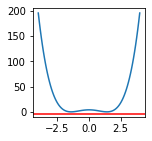

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(thetas.numpy(), x.numpy())
ax.axhline(xo.numpy(), c="r")
plt.show()

In [15]:
likelihoods = torch.distributions.Normal((thetas**2 - 2)**2, 0.1*torch.ones(1))
s = likelihoods.sample((1000,))

In [16]:
dists = (torch.abs(s - xo)).mean(dim=0)

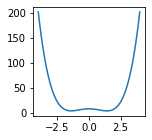

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(thetas.numpy(), dists.numpy())
plt.show()

tensor(0.1117)


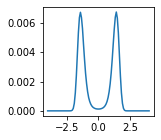

tensor(1.0132)


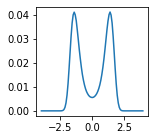

tensor(1.9128)


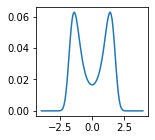

tensor(2.4739)


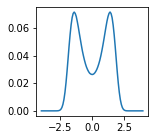

tensor(2.7761)


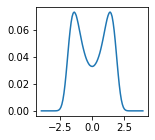

tensor(2.9184)


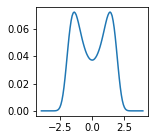

tensor(2.9660)


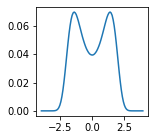

tensor(2.9585)


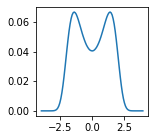

tensor(2.9189)


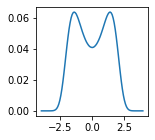

tensor(2.8612)


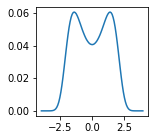

tensor(2.7937)


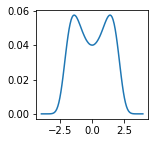

tensor(2.7216)


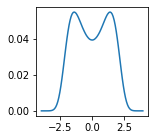

tensor(2.6480)


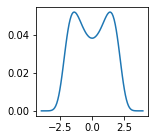

tensor(2.5748)


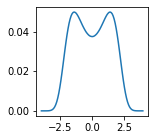

tensor(2.5032)


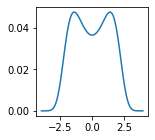

tensor(2.4338)


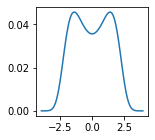

tensor(2.3670)


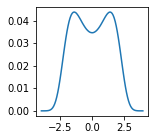

tensor(2.3030)


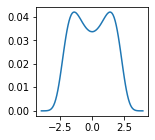

tensor(2.2418)


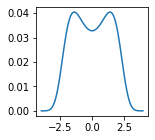

In [18]:
for beta in range(1, 20, 1):
    func1 = torch.exp(-1/beta*dists) / beta
    normalizer = func1.sum()
    print(normalizer)
    
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.plot(thetas.numpy(), func1.numpy())
    plt.show()

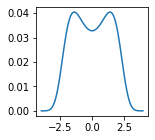

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(thetas.numpy(), func1.numpy())
plt.show()

### Example 2

In [20]:
xo = torch.zeros(1)
dist1 = torch.distributions.Normal(zeros(1), 10.0*ones(1))
dist2 = torch.distributions.Normal(zeros(1), 1.0*ones(1))

s1 = dist1.sample((10_000,))
s2 = dist2.sample((10_000,))
xos = torch.linspace(-50, 50, 200)
distance1 = (torch.abs(xos - s1)).mean(dim=0)
distance2 = (torch.abs(xos - s2)).mean(dim=0)

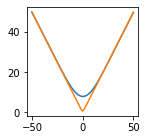

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(xos.numpy(), distance1.numpy())
_ = ax.plot(xos.numpy(), distance2.numpy())
plt.show()

In [24]:
beta = 1.0
func1 = torch.exp(-1/beta*distance1)
func2 = torch.exp(-1/beta*distance2)
# func1 /= torch.sum(func1)
# func2 /= torch.sum(func2)

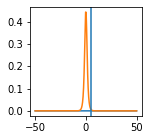

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(xos.numpy(), func1.numpy())
_ = ax.plot(xos.numpy(), func2.numpy())
_ = ax.axvline(xos.numpy()[110])
plt.show()

In [26]:
for beta in range(1, 50, 5):
    func1 = torch.exp(-1/beta*distance1)
    func2 = torch.exp(-1/beta*distance2)
    func1 /= torch.sum(func1)
    func2 /= torch.sum(func2)

    p_of_x = func1[120]
    print(p_of_x)

tensor(0.0013)
tensor(0.0112)
tensor(0.0102)
tensor(0.0091)
tensor(0.0083)
tensor(0.0077)
tensor(0.0073)
tensor(0.0070)
tensor(0.0068)
tensor(0.0066)


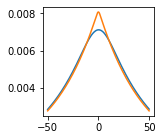

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(xos.numpy(), func1.numpy())
_ = ax.plot(xos.numpy(), func2.numpy())
plt.show()

In [28]:
p_of_x = func1[-1]
print(p_of_x)

tensor(0.0029)


In [29]:
beta_range = torch.logspace(-5, 4, 10)
normalizing_constants = []
for beta in beta_range:
    print("beta", beta)
    gbi_potential = GBIPotential(
        prior=prior,
        gen_llh_fn=generalized_likelihood,
        beta=beta,
    )
    
    # Estimate Z_1(beta)
    theta_samples = prior.sample((1000,))
    x_samples = net.sample(1, context=theta_samples)[0]
    x_probs = net.log_prob(x_samples, context=theta_samples).exp().mean(dim=1)
    z1_of_beta = (gbi_potential(x_samples, track_gradients=False).exp() / x_probs).mean()
    
    # Estimate Z_2
    norm_constant = 0.0
    num_runs = 10
    for _ in range(num_runs):
        prior_samples = prior.sample((10,))
        norm_constant += gbi_potential(prior_samples, track_gradients=False).exp().mean() / z1_of_beta
    norm_constant /= num_runs
    normalizing_constants.append(norm_constant)

beta tensor(1.0000e-05)


/home/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


ValueError: Number of input items must be equal to number of context items.

In [31]:
normalizing_constants = torch.stack(normalizing_constants)

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl

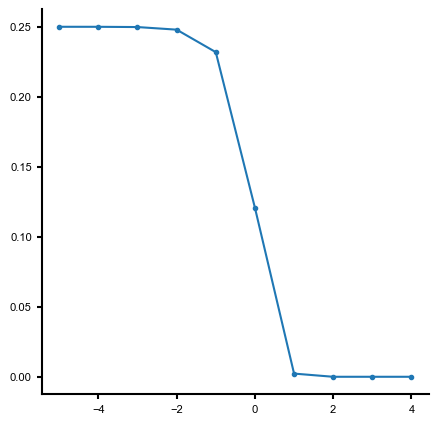

In [33]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(beta_range.log10().numpy(), normalizing_constants.numpy())
    ax.plot(beta_range.log10().numpy(), normalizing_constants.numpy())
    plt.show()